# Calibration using Zhang's procedure

In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
import cv2 # OpenCV
from calibration import Calibrator

## 1. Calibrate using Zhang procedure, i.e., find the intrinsic parameters K and, for each image, the pair of R, t (extrinsic);

In [2]:
calibrator = Calibrator()

folderpath = './images'
images_path = [os.path.join(folderpath, imagename) for imagename in os.listdir(folderpath) if imagename.endswith(".tiff")]
images_path.sort()
limages = []

for path in images_path:
    image = cv2.imread(path)
    limages.append(image)


calibrator.fit(limages, radial_distortion=False, iterative=False)
print("K:",calibrator.K)
print("Rotation matrices:")
for i,R in enumerate(calibrator.rotations):
    print(f"R{i+1}:{R}")
print("Translation vectors:")
for i,t in enumerate(calibrator.translations):
    print(f"t{i+1}:{t}")

[ERROR:1@0.680] global ocl.cpp:4684 createFromBinary OpenCL error CL_INVALID_VALUE (-30) during call: clCreateProgramWithBinary


K: [[1.74323141e+03 1.06181254e+00 6.31591695e+02]
 [0.00000000e+00 1.74367260e+03 4.97111448e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation matrices:
R1:[[-0.3377103   0.91188936 -0.23325853]
 [ 0.94007693  0.33913737 -0.03523086]
 [ 0.04698004 -0.23117879 -0.97177633]]
R2:[[ 0.88161749 -0.41253575  0.22927026]
 [-0.46352282 -0.84828965  0.25602982]
 [ 0.08886614 -0.33199237 -0.93908673]]
R3:[[-0.54238588  0.67880717 -0.49501352]
 [ 0.81125958  0.57631125 -0.09860646]
 [ 0.21834709 -0.45506721 -0.8632719 ]]
R4:[[ 0.85857565 -0.4706886   0.20322424]
 [-0.49753955 -0.86059619  0.10875932]
 [ 0.12370224 -0.1944902  -0.97307313]]
R5:[[ 0.72265268 -0.65130423  0.2314647 ]
 [-0.67740049 -0.73393088  0.04973973]
 [ 0.13748339 -0.19273886 -0.97157092]]
R6:[[-0.14495179  0.96154134 -0.23329644]
 [ 0.9242751   0.21574096  0.31491488]
 [ 0.35313527 -0.16998262 -0.92000075]]
R7:[[-0.43544613  0.88351987 -0.17256683]
 [ 0.87187499  0.46163709  0.16347842]
 [ 0.22409968 -0.07927065 

## 2. Choose one of the calibration images and compute the total reprojection error for all the grid points (adding a figure with the reprojected points);
We will perform the procedure on the 8-th image, first with the basic procedure then with the iterative one
### Basic procedure

Text(0.5, 1.0, 'Total reprojection error: 206.43242480122763')

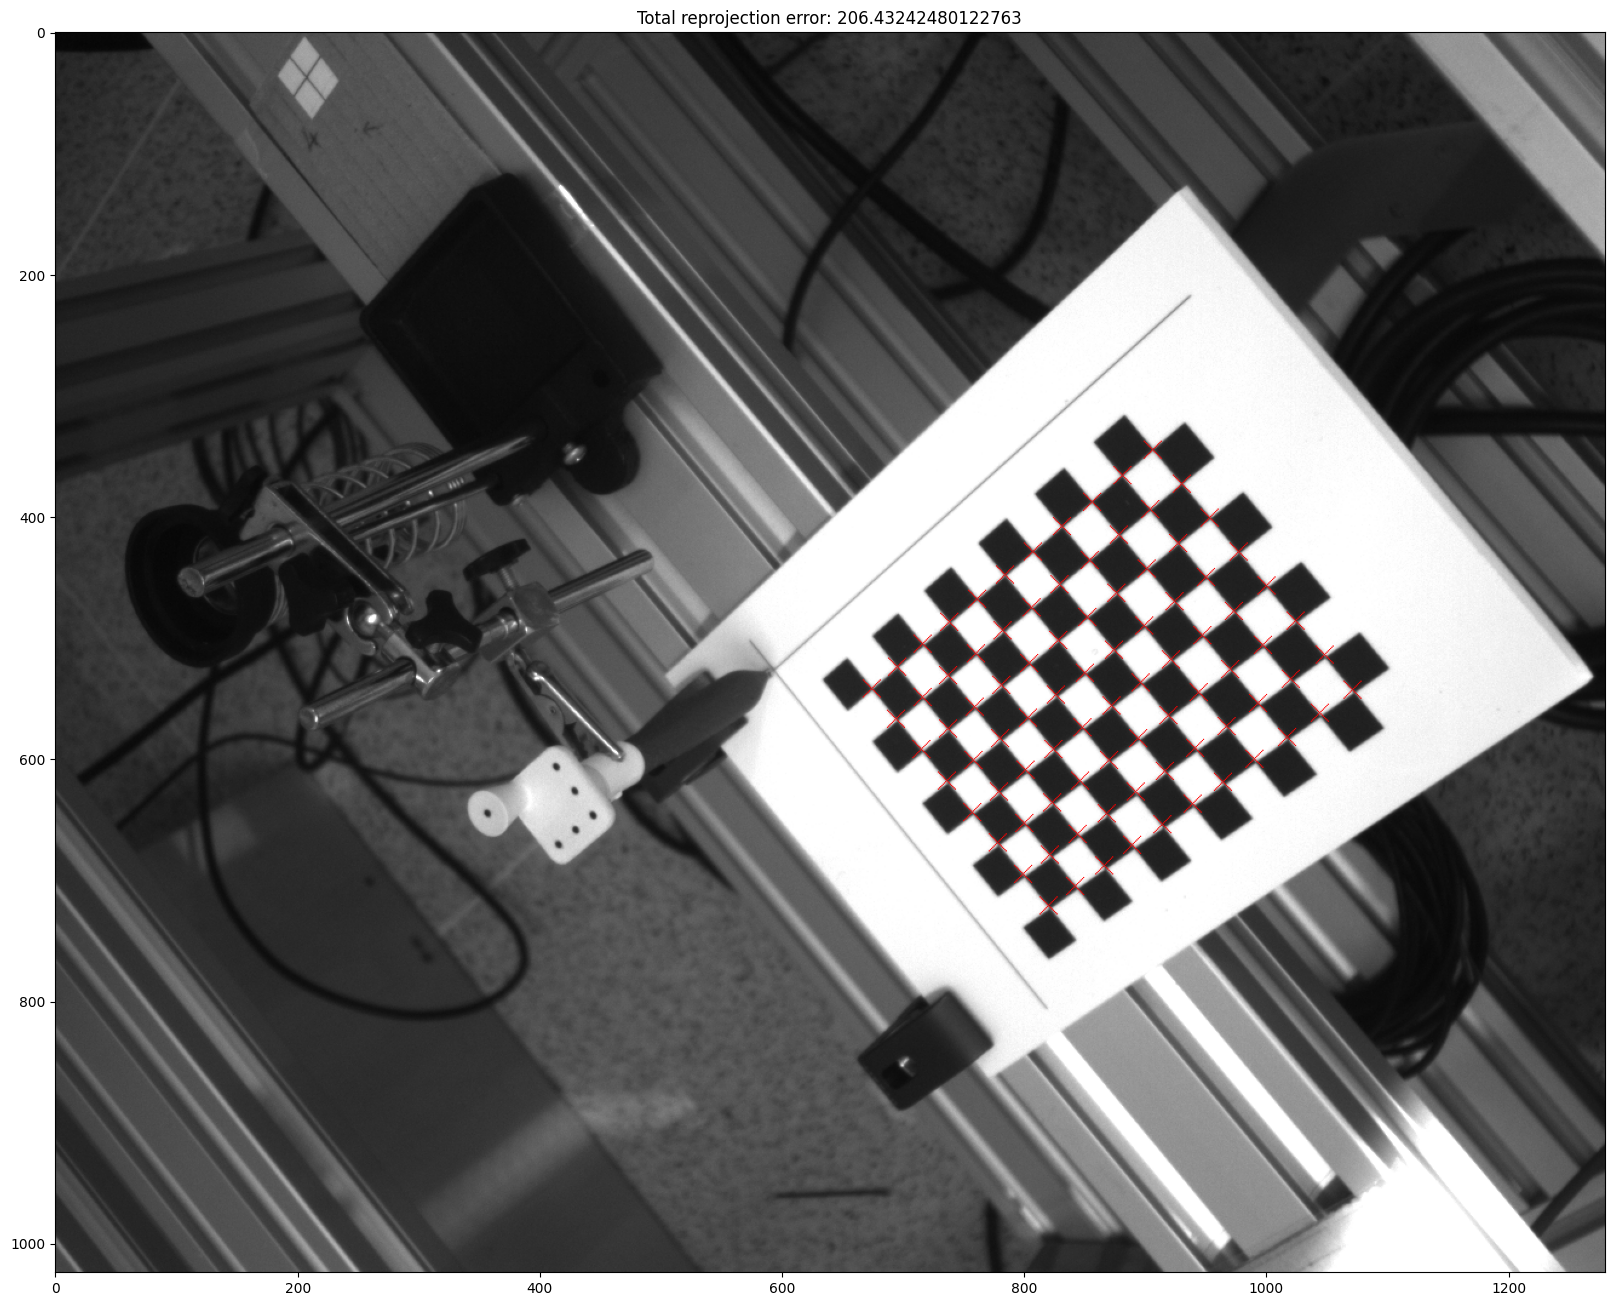

In [3]:
calibrator.fit(limages, radial_distortion=False, iterative=False)
index = 7
R, P, error = calibrator.real_coords, calibrator.projection_matrices[index], calibrator.reprojection_errors[index]
image7 = cv2.imread(images_path[index])
proj_chess = np.transpose(P@R.T)
proj_chess[:,0] = proj_chess[:,0]/proj_chess[:,2]
proj_chess[:,1] = proj_chess[:,1]/proj_chess[:,2]
proj_chess = proj_chess[:,:-1]
copy1 = image7.copy()
for point in proj_chess:
    copy1 = cv2.drawMarker(img=copy1,
                           position=tuple(np.array(point, dtype=np.int32)),
                           color=(255,0,0),
                           markerType=cv2.MARKER_TILTED_CROSS,
                           thickness=1,
                           markerSize=15
                           )
plt.figure(figsize=(20,20))
plt.imshow(copy1)
plt.title(f"Total reprojection error: {error}")

### Iterative refinement

Text(0.5, 1.0, 'Total reprojection error: 1.2723566509967064')

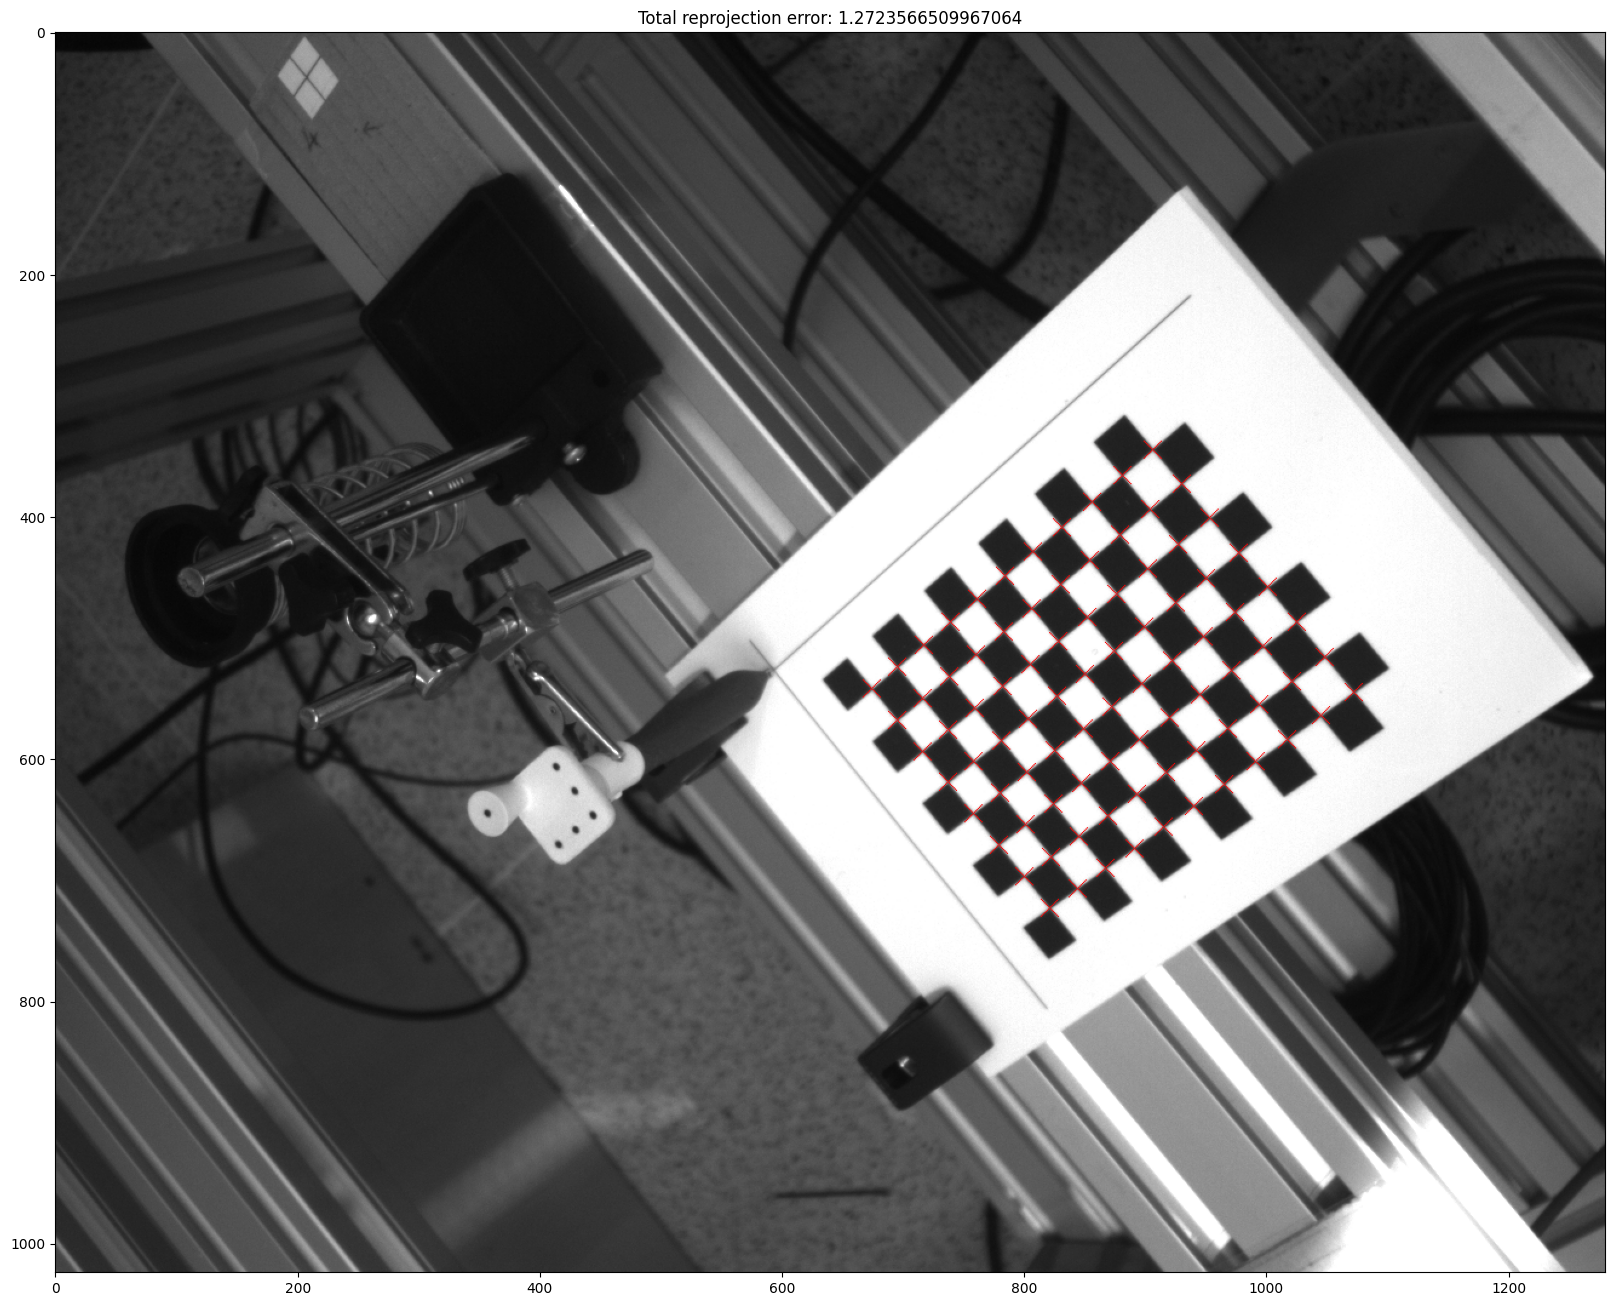

In [4]:
calibrator.fit(limages, radial_distortion=False, iterative=True)
index = 7
R, P, error = calibrator.real_coords, calibrator.projection_matrices[index], calibrator.reprojection_errors[index]
image7 = cv2.imread(images_path[index])
proj_chess = np.transpose(P@R.T)
proj_chess[:,0] = proj_chess[:,0]/proj_chess[:,2]
proj_chess[:,1] = proj_chess[:,1]/proj_chess[:,2]
proj_chess = proj_chess[:,:-1]
copy1 = image7.copy()
for point in proj_chess:
    copy1 = cv2.drawMarker(img=copy1,
                           position=tuple(np.array(point, dtype=np.int32)),
                           color=(255,0,0),
                           markerType=cv2.MARKER_TILTED_CROSS,
                           thickness=1,
                           markerSize=15
                           )
plt.figure(figsize=(20,20))
plt.imshow(copy1)
plt.title(f"Total reprojection error: {error}")

## 3. Superimpose an object (for instance, a cylinder), to the calibration plane, in all the images employed for the calibration;

In [5]:
# Funzione generata con Microsoft Copilot
def create_image_grid(image_list, grid_size, is_bw=False):
    rows, cols = grid_size
    if len(image_list) != rows * cols:
        raise ValueError("Il numero di immagini non corrisponde alla dimensione della griglia")

    img_height, img_width = image_list[0].shape[:2]

    if not is_bw:
        grid_image = np.zeros((rows * img_height, cols * img_width, 3), dtype=np.uint8)
    else:
        grid_image = np.zeros((rows * img_height, cols * img_width), dtype=np.uint8)

    for idx, img in enumerate(image_list):
        row = idx // cols
        col = idx % cols
        grid_image[row * img_height:(row + 1) * img_height, col * img_width:(col + 1) * img_width] = img

    return grid_image

In [6]:
pts = cv2.ellipse2Poly((44,55), (22,22), 0, 0, 360, 1)
pts = pts/1000
et_low = np.empty_like(pts)
et_high = np.empty_like(et_low)
pts_low = np.hstack((pts, np.zeros((pts.shape[0],1)), np.ones((pts.shape[0],1))))
pts_high = np.hstack((pts, np.full((pts.shape[0],1), 0.055), np.ones((pts.shape[0],1))))

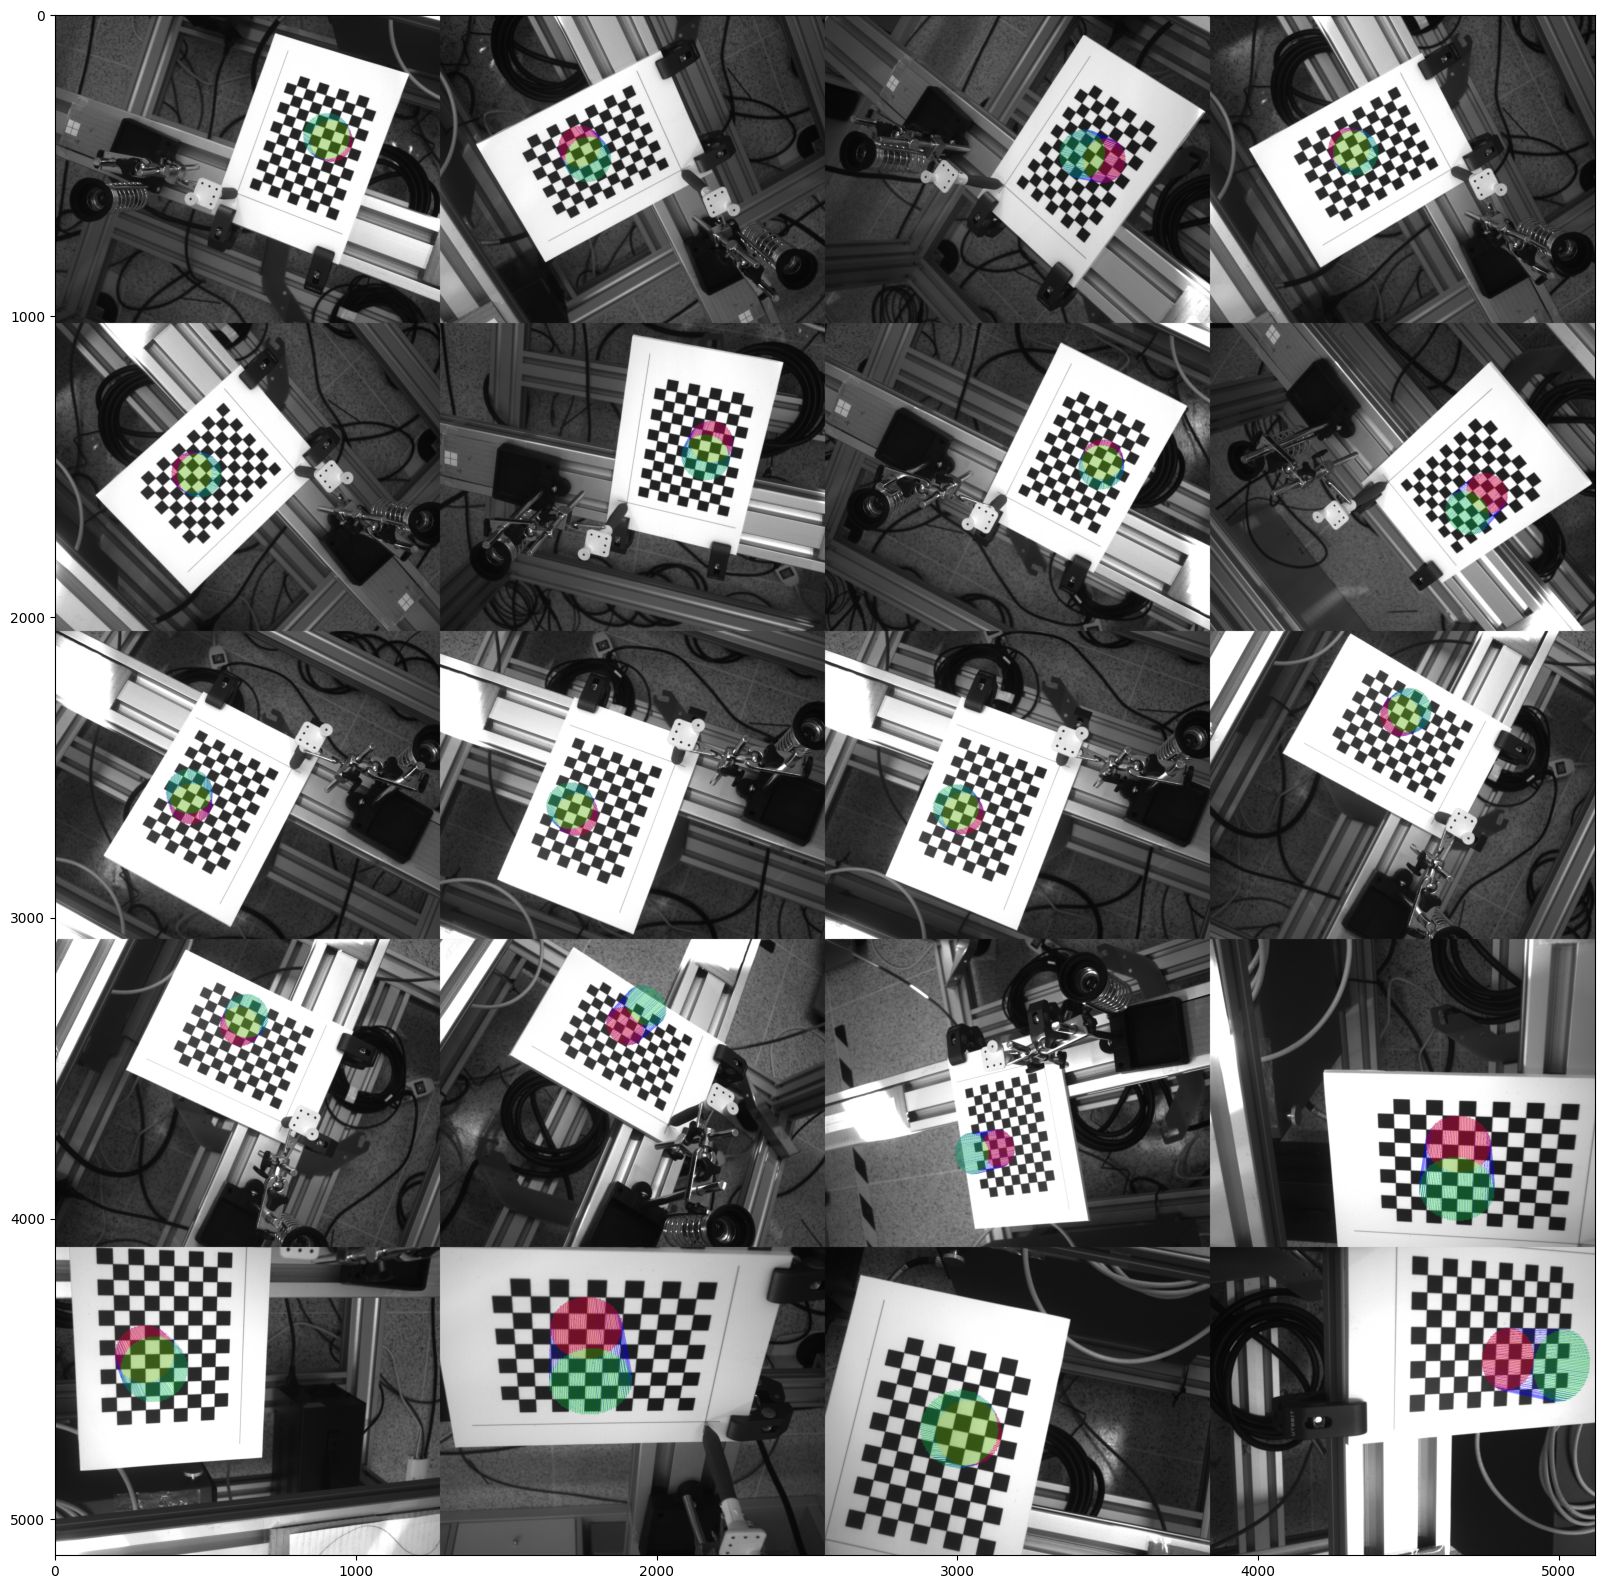

In [7]:
image_list = []
for i,path in enumerate(images_path):
    original = cv2.imread(path)
    P = calibrator.projection_matrices[i]

    proj_low = np.transpose(P @ pts_low.T)
    et_low[:,0] = proj_low[:,0]/proj_low[:,2]
    et_low[:,1] = proj_low[:,1]/proj_low[:,2]

    proj_high = np.transpose(P @ pts_high.T)
    et_high[:,0] = proj_high[:,0]/proj_high[:,2]
    et_high[:,1] = proj_high[:,1]/proj_high[:,2]

    img2 = original.copy()
    img2 = cv2.fillConvexPoly(img2,np.array(et_low, dtype=np.int32),(255,0,0))
    img3 = cv2.fillConvexPoly(img2.copy(),np.array(et_high, dtype=np.int32),(0,255,0))
    img4 = original.copy()
    for i in range(et_low.shape[0]):
        img4 = cv2.line(img4, tuple(np.array(et_low[i], dtype=np.int32)), tuple(np.array(et_high[i], dtype=np.int32)),(0,0,255))
    img2 = cv2.addWeighted(img2, 0.5, original, 0.5, 0)
    img3 = cv2.addWeighted(img2, 0.5, img3, 0.5, 0)
    img4 = cv2.addWeighted(img3, 0.5, img4, 0.5, 0)
    image_list.append(img4)

compound = create_image_grid(image_list, (5,4))
plt.figure(figsize=(20,20))
plt.imshow(compound)

[np.float64(0.7521988474129775), np.float64(0.8944832280165241), np.float64(1.1793932503336448), np.float64(0.8095481289822812), np.float64(0.7906656295312104), np.float64(0.8075650248513148), np.float64(0.6764945113911919), np.float64(1.338165761908603), np.float64(0.8819369477178722), np.float64(0.9414414449768768), np.float64(0.876336040383271), np.float64(1.0400754302876445), np.float64(1.0939729805952405), np.float64(1.9762552118663397), np.float64(1.2272264401900705), np.float64(3.154802326329442), np.float64(1.838176173172321), np.float64(4.513405627740939), np.float64(2.143082179274144), np.float64(3.0304860643021216)]


Text(0.5, 1.0, 'k1:-0.03627164730420251, k2:0.13451035909218356')

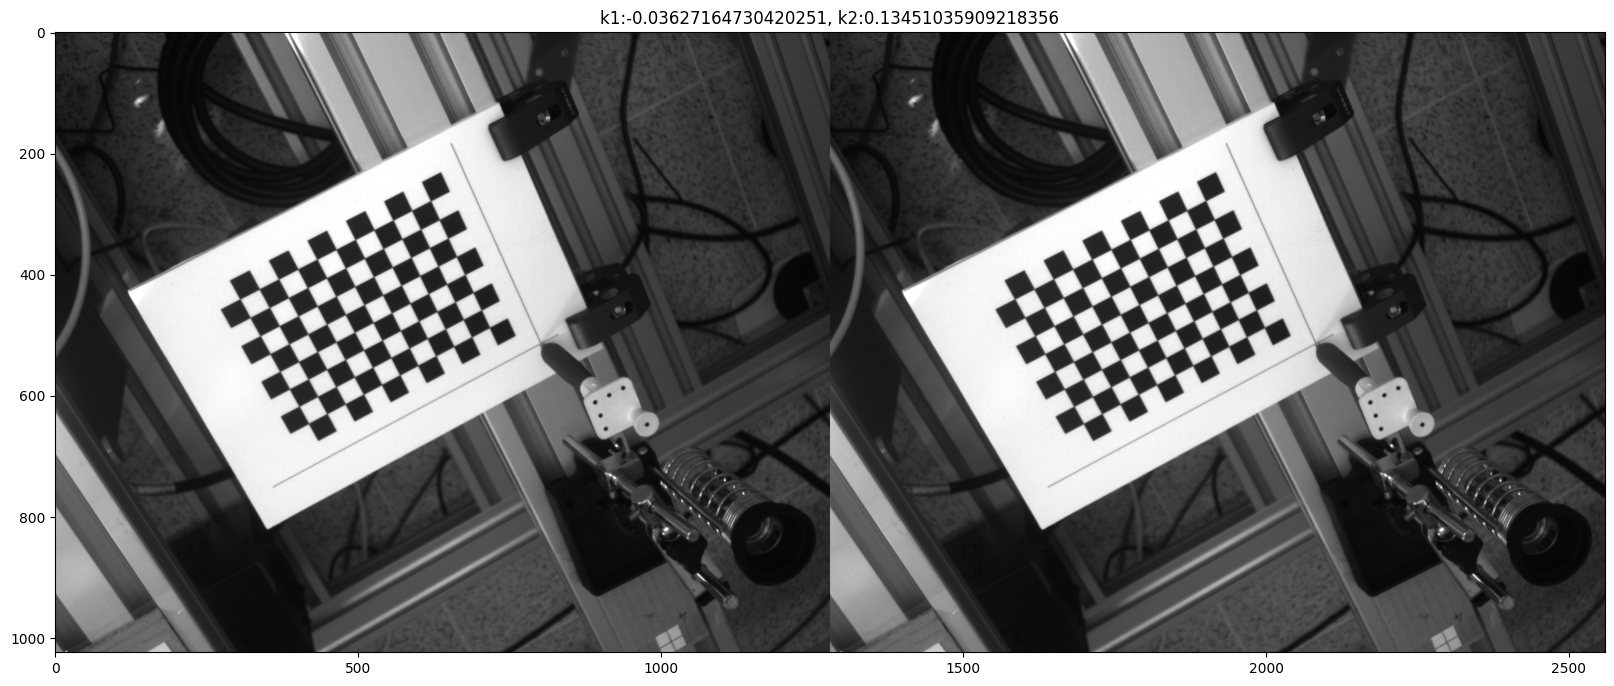

In [8]:
calibrator.fit(limages, radial_distortion=True, iterative=True)
print(calibrator.reprojection_errors)
index = 1
image7 = cv2.imread(images_path[index])
image7 = cv2.cvtColor(image7.copy(), cv2.COLOR_BGR2GRAY)
undistorted7 = calibrator.compensate_radial_distortion(image7)
limage1 = [image7, undistorted7]
compound = create_image_grid(limage1, (1,2), True)
plt.figure(figsize=(20,20))
plt.imshow(compound, cmap='gray')
plt.title(f"k1:{calibrator.distortion_parameters[0]}, k2:{calibrator.distortion_parameters[1]}")